In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [2]:
# parameters
train = True
strategy_name = "etfstsm"

strategy_name = f"training_{strategy_name}" if train else strategy_name

# paths
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
dirs = os.listdir(os.path.join(outputs_path, strategy_name))

In [3]:
dirs

['Sharpe_means_0.95_10',
 'MaxDD_means_0.05_100',
 'Sharpe_means_0.95_100',
 'Sharpe_means_0.05_100',
 'MaxDD_means_0.95_100']

In [70]:
dir = "Sharpe_means_0.05_100" # next(iter(dirs))

print(dir)

utility = dir.split("_")[0]
functional = dir.split("_")[1]
alpha = dir.split("_")[2]
Bsize = dir.split("_")[3]

args = load_pickle(os.path.join(outputs_path, strategy_name, dir, "args.pickle"))
optmization = load_pickle(os.path.join(outputs_path, strategy_name, dir, "opt_results.pickle"))
portfolio = load_pickle(os.path.join(outputs_path, strategy_name, dir, "portfolio_results.pickle"))

Sharpe_means_0.05_100


In [71]:
portfolio.keys()

dict_keys(['bars', 'signals', 'forecasts', 'vols', 'portfolio_returns', 'agg_portfolio_returns', 'scaled_portfolio_returns', 'agg_scaled_portfolio_returns'])

In [72]:
optmization.keys()

dict_keys(['hyperparameters', 'utilities', 'final_utility', 'robust_parameter'])

In [73]:
len(optmization['utilities'])

223

In [74]:
daily_returns = portfolio["agg_scaled_portfolio_returns"]
daily_rolling_vols = daily_returns.rolling(252).std() * 100
daily_cumm_returns = daily_returns.cumsum()

mean_returns = daily_returns.mean().iloc[0] * 100
vol_returns = daily_returns.std().iloc[0] * 100
sharpe = mean_returns / vol_returns * np.sqrt(252)

## Distribution of Utilities

In [75]:
utilities_val = []
for i in range(len(optmization['utilities'])):

    if functional == "means":
        utility_val = torch.mean(optmization['utilities'][i]).item()
    else:
        raise Exception(f"functional not registered: {functional}")

    utilities_val.append(utility_val)

average_utility = np.mean(utilities_val)
utility_val_df = pd.DataFrame(utilities_val, columns=[utility])

Text(0.5, 1.0, 'Histogram of Utilities: alpha=0.05, Bsize=100')

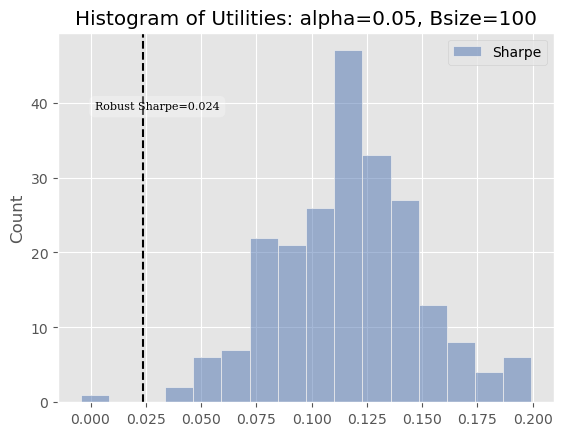

In [76]:
ax = sns.histplot(data=utility_val_df, palette="deep")

ax.annotate(
    f"Robust {utility}={np.round(sharpe, 3)}",
    xy=(0.2, 0.8),
    xycoords="axes fraction",
    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.3),
    ha="center",
    va="center",
    family="serif",
    size="8"
)

plt.axvline(x=sharpe, color='black', linestyle='--')
plt.title(f"Histogram of Utilities: alpha={alpha}, Bsize={Bsize}")

Text(0.5, 1.0, 'Histogram of Utilities: alpha=0.95, Bsize=10')

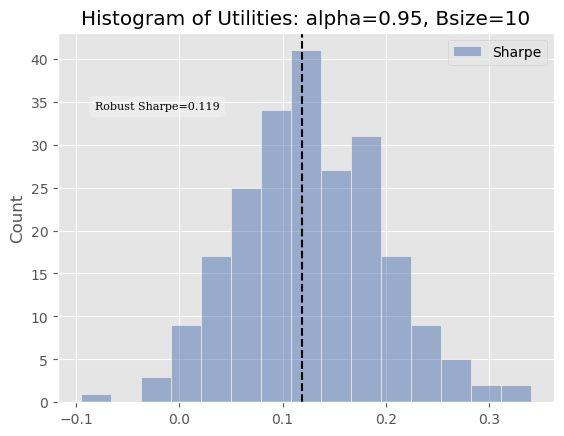

In [69]:
ax = sns.histplot(data=utility_val_df, palette="deep")

ax.annotate(
    f"Robust {utility}={np.round(sharpe, 3)}",
    xy=(0.2, 0.8),
    xycoords="axes fraction",
    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.3),
    ha="center",
    va="center",
    family="serif",
    size="8"
)

plt.axvline(x=sharpe, color='black', linestyle='--')
plt.title(f"Histogram of Utilities: alpha={alpha}, Bsize={Bsize}")

## Opitimal Strategy

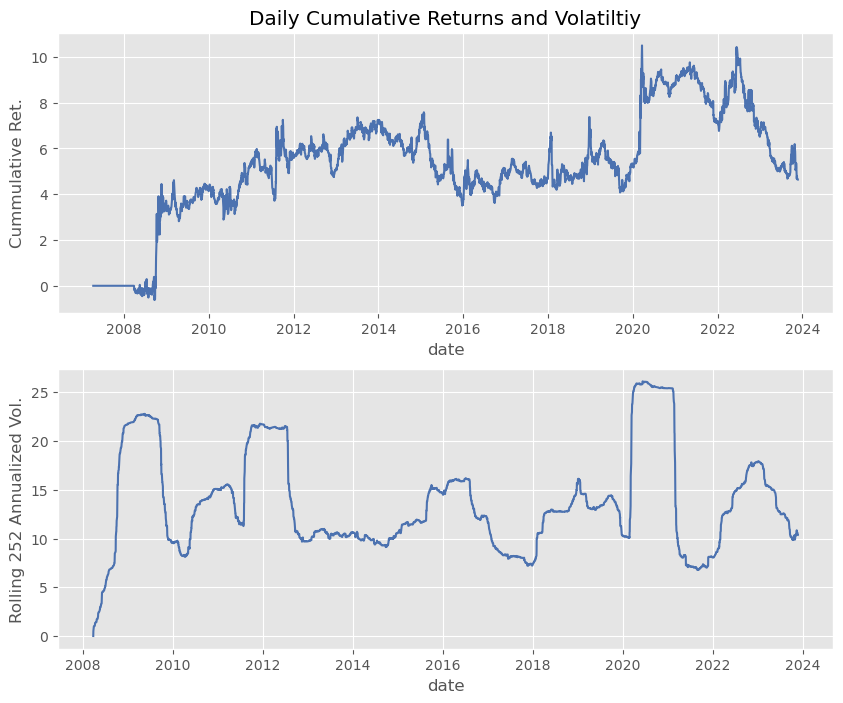

In [10]:
# Create a figure with two subplots (axes), one on top of the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # Adjust figsize as needed

# First subplot
ax1.set_title("Daily Cumulative Returns and Volatiltiy")
sns.lineplot(data=daily_cumm_returns, linewidth=1.5, palette="deep", ax=ax1)
ax1.set_ylabel("Cummulative Ret.")
ax1.get_legend().remove()

# First subplot
sns.lineplot(data=daily_rolling_vols, linewidth=1.5, palette="deep", ax=ax2)
ax2.set_ylabel("Rolling 252 Annualized Vol.")
ax2.get_legend().remove()

Text(0.5, 1.0, 'Daily Returns')

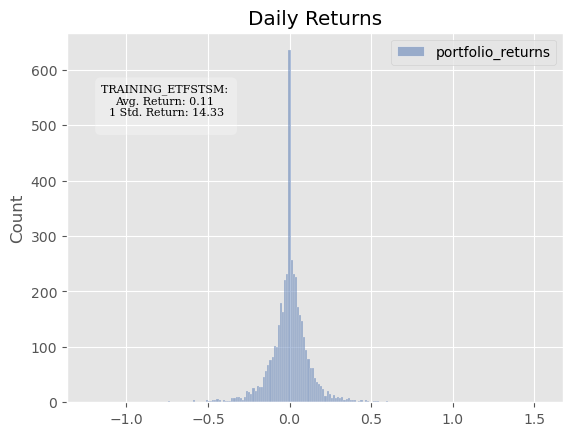

In [11]:
ax = sns.histplot(data=daily_returns, palette="deep")
ax.annotate(
    "{}: \nAvg. Return: {} \n1 Std. Return: {}\n".format(
        strategy_name.upper(), (daily_returns.mean().iloc[0] * 100).round(2), (daily_returns.std().iloc[0] * 100).round(2)
    ),
    xy=(0.2, 0.8),
    xycoords="axes fraction",
    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.3),
    ha="center",
    va="center",
    family="serif",
    size="8"
)
plt.title("Daily Returns")